In [3]:
cd ..

/export/kaspar/SimGCD


In [35]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(description='cluster', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--batch_size', default=128, type=int)
    parser.add_argument('--num_workers', default=8, type=int)
    parser.add_argument('--eval_funcs', nargs='+', help='Which eval functions to use', default=['v2', 'v2p'])

    parser.add_argument('--warmup_model_dir', type=str, default=None)
    parser.add_argument('--dataset_name', type=str, default='cifar100', help='options: cifar10, cifar100, imagenet_100, cub, scars, fgvc_aricraft, herbarium_19')
    parser.add_argument('--prop_train_labels', type=float, default=0.5)
    parser.add_argument('--use_ssb_splits', action='store_true', default=True)

    parser.add_argument('--grad_from_block', type=int, default=11)
    parser.add_argument('--lr', type=float, default=0.1)
    parser.add_argument('--gamma', type=float, default=0.1)
    parser.add_argument('--momentum', type=float, default=0.9)
    parser.add_argument('--weight_decay', type=float, default=1e-4)
    parser.add_argument('--epochs', default=200, type=int)
    parser.add_argument('--exp_root', type=str, default='exp_root')
    parser.add_argument('--transform', type=str, default='imagenet')
    parser.add_argument('--sup_weight', type=float, default=0.35)
    parser.add_argument('--n_views', default=2, type=int)
    
    parser.add_argument('--memax_weight', type=float, default=2)
    parser.add_argument('--warmup_teacher_temp', default=0.07, type=float, help='Initial value for the teacher temperature.')
    parser.add_argument('--teacher_temp', default=0.04, type=float, help='Final value (after linear warmup)of the teacher temperature.')
    parser.add_argument('--warmup_teacher_temp_epochs', default=30, type=int, help='Number of warmup epochs for the teacher temperature.')

    parser.add_argument('--fp16', action='store_true', default=False)
    parser.add_argument('--print_freq', default=10, type=int)
    parser.add_argument('--exp_name', default=None, type=str)

    """
    Size of Memory Queue
    """
    parser.add_argument('--mem_queue', type=bool, default=False, help='whether to use the memory queue')
    parser.add_argument('--mem_q_size', type=int, default= 32768, help='How many images to store in the queue size')
    parser.add_argument('--mem_p', type=float, default = 0., help='Probability of selecting the memory queue element instead of the other view')
    parser.add_argument('--mem_direct_knn', type=bool, default = False, help='If true, the KNN queue will be the first view, if false the second')

    return parser.parse_args('')

args = get_args()

In [36]:
args.dataset_name

'cifar100'

In [37]:
from data.augmentations import get_transform
from data.get_datasets import get_datasets, get_class_splits
from model import DINOHead, info_nce_logits, SupConLoss, DistillLoss, ContrastiveLearningViewGenerator, get_params_groups
import torch
from torch.utils.data import DataLoader

args = get_class_splits(args)

args.num_labeled_classes = len(args.train_classes)
args.num_unlabeled_classes = len(args.unlabeled_classes)

# ----------------------
# BASE MODEL
# ----------------------
args.interpolation = 3
args.crop_pct = 0.875

args.image_size = 224
args.feat_dim = 768
args.num_mlp_layers = 3
args.mlp_out_dim = args.num_labeled_classes + args.num_unlabeled_classes


train_transform, test_transform = get_transform(args.transform, image_size=args.image_size, args=args)
train_transform = ContrastiveLearningViewGenerator(base_transform=train_transform, n_views=args.n_views)
# --------------------
# DATASETS
# --------------------
train_dataset, test_dataset, unlabelled_train_examples_test, datasets = get_datasets(args.dataset_name,
                                                                                    train_transform,
                                                                                    test_transform,
                                                                                    args)

# --------------------
# SAMPLER
# Sampler which balances labelled and unlabelled examples in each batch
# --------------------
label_len = len(train_dataset.labelled_dataset)
unlabelled_len = len(train_dataset.unlabelled_dataset)
sample_weights = [1 if i < label_len else label_len / unlabelled_len for i in range(len(train_dataset))]
sample_weights = torch.DoubleTensor(sample_weights)
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(train_dataset))

# --------------------
# DATALOADERS
# --------------------
train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False,
                        sampler=sampler, drop_last=True, pin_memory=True)
batch = next(iter(train_loader))

/export/kaspar/miniconda3/envs/gcd/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


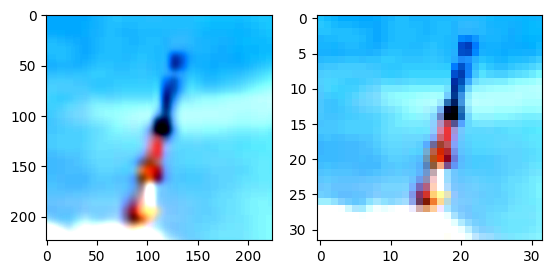

In [53]:
import matplotlib.pyplot as plt
images, class_labels, uq_idxs, mask_lab, idxs = batch

k = 121

fig, axs = plt.subplots(1,2)

im_1 = images[0][k].permute(1,2,0)
im_2 = ds[uq_idxs[k]][0].permute(1,2,0)
ims = [im_1,im_2]

for j,ax in enumerate(axs):
    ax.imshow(ims[j])

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


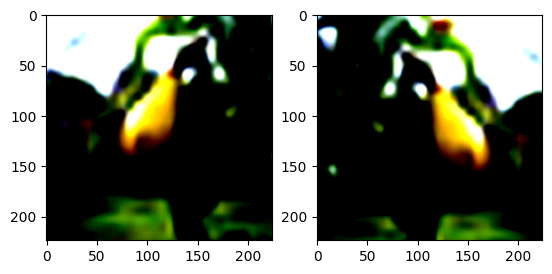

In [45]:
import matplotlib.pyplot as plt
i=30681

fig, axs = plt.subplots(1,2)
for j,ax in enumerate(axs):
    ax.imshow(train_dataset[i][0][j].permute(1,2,0))

plt.show()


In [47]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

cifar_100_root = '/export/shared/DataSets/vision_benchmarks/'

def get_transforms():
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        interpolation = 3
        crop_pct = 0.875
        image_size=32

        train_transform = transforms.Compose([
                    transforms.Resize(int(image_size / crop_pct), interpolation),
                    transforms.RandomCrop(image_size),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ColorJitter(),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=torch.tensor(mean),
                        std=torch.tensor(std))
                ])
        
        return train_transform

train_transform= get_transforms()


class CustomCIFAR100(CIFAR100):

    def __init__(self, *args, **kwargs):
        super(CustomCIFAR100, self).__init__(*args, **kwargs)

        self.uq_idxs = np.array(range(len(self)))

    def __getitem__(self, item):
        img, label = super().__getitem__(item)
        uq_idx = self.uq_idxs[item]

        return img, label, uq_idx

    def __len__(self):
        return len(self.targets)
    
whole_training_set = CustomCIFAR100(root=cifar_100_root, transform=train_transform, train=True)




ds = CIFAR100(root = '/export/shared/DataSets/vision_benchmarks/',transform=train_transform, train = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50000


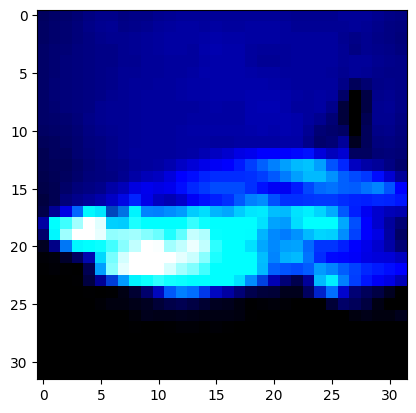

In [33]:
print(len(ds))

plt.imshow(ds[-1][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50000


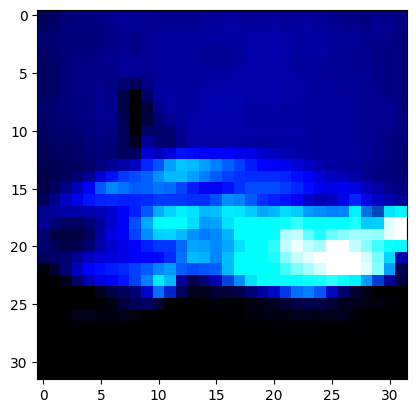

In [34]:
print(len(whole_training_set))
plt.imshow(whole_training_set[-1][0].permute(1,2,0))

In [78]:
a = torch.arange(50).reshape(10,5)
idxs = torch.randint(10, size = (6,))

knn_ids = torch.randint(5, size =(6,))
print(a)
print(idxs)

print(knn_ids)
print(a[idxs,knn_ids])

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49]])
tensor([5, 7, 6, 9, 3, 3])
tensor([4, 3, 2, 2, 0, 0])
tensor([29, 38, 32, 47, 15, 15])
